# Script to identify moving groups within Gaia wide binaries

In [1]:
import os
import sys
sys.path.append('../src')
import P_binary
import P_random
import P_posterior
import const as c
import time
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import corner
import pickle


%matplotlib inline

### Load TGAS catalog and matches

In [2]:
# Read in sample from TGAS table
dtype = [('ID','<i8'),('tyc','S11'),('hip','<i8'),('ra','<f8'),('dec','<f8'),('mu_ra','<f8'),('mu_dec','<f8'), \
     ('mu_ra_err','<f8'),('mu_dec_err','<f8'),('plx','<f8'),('plx_err','<f8')]

tgas_full = np.array([], dtype=dtype)

for i in np.arange(16):
    if i < 10:
        filename = ('../data/TGAS/TgasSource_000-000-00' + str(i) + '.csv')
    else:
        filename = ('../data/TGAS/TgasSource_000-000-0' + str(i) + '.csv')

    print filename
    tgas_tmp = Table.read(filename, format='csv', guess=True)
    
    

    tgas = np.zeros(len(tgas_tmp), dtype=dtype)

    tgas['ID'] = tgas_tmp['source_id']
    tgas['tyc'] = tgas_tmp['tycho2_id']
    tgas['hip'] = tgas_tmp['hip']
    tgas['ra'] = tgas_tmp['ra']
    tgas['dec'] = tgas_tmp['dec']
    tgas['mu_ra'] = tgas_tmp['pmra']
    tgas['mu_ra_err'] = tgas_tmp['pmra_error']
    tgas['mu_dec'] = tgas_tmp['pmdec']
    tgas['mu_dec_err'] = tgas_tmp['pmdec_error']
    tgas['plx'] = tgas_tmp['parallax']
    tgas['plx_err'] = tgas_tmp['parallax_error']

    tgas_full = np.append(tgas_full, tgas)

../data/TGAS/TgasSource_000-000-000.csv
../data/TGAS/TgasSource_000-000-001.csv
../data/TGAS/TgasSource_000-000-002.csv
../data/TGAS/TgasSource_000-000-003.csv
../data/TGAS/TgasSource_000-000-004.csv
../data/TGAS/TgasSource_000-000-005.csv
../data/TGAS/TgasSource_000-000-006.csv
../data/TGAS/TgasSource_000-000-007.csv
../data/TGAS/TgasSource_000-000-008.csv
../data/TGAS/TgasSource_000-000-009.csv
../data/TGAS/TgasSource_000-000-010.csv
../data/TGAS/TgasSource_000-000-011.csv
../data/TGAS/TgasSource_000-000-012.csv
../data/TGAS/TgasSource_000-000-013.csv
../data/TGAS/TgasSource_000-000-014.csv
../data/TGAS/TgasSource_000-000-015.csv


In [3]:
idx_max = len(tgas_full)
print idx_max

2057050


In [64]:
directory = '../data/TGAS/'

TGAS_prob = pickle.load( open(directory + "TGAS_match_1.p", "rb"))

for filename in os.listdir('../data/TGAS'):
    if filename.endswith('_1.p'): continue
    if not filename.endswith('.p'): continue
    if not filename.startswith('TGAS_match_'): continue
        
    TGAS_tmp = pickle.load(open(directory + filename, "rb"))
    TGAS_prob = np.append(TGAS_prob, TGAS_tmp)
    
print TGAS_prob.dtype
print len(TGAS_prob)


# Detection probability: 90%
TGAS_prob = TGAS_prob[TGAS_prob['P_posterior']>0.9]
print len(TGAS_prob)

[('i_1', '<i4'), ('i_2', '<i4'), ('ID_1', '<i4'), ('ID_2', '<i4'), ('P_random', '<f8'), ('P_binary', '<f8'), ('P_posterior', '<f8'), ('theta', '<f8'), ('mu_ra_1', '<f8'), ('mu_dec_1', '<f8'), ('mu_ra_2', '<f8'), ('mu_dec_2', '<f8'), ('plx_1', '<f8'), ('plx_2', '<f8')]
125894
5207


In [25]:
def deg_to_rad(theta):
    """ Convert from degrees to radians """
    return np.pi * theta / 180.0

def rad_to_deg(theta):
    """ Convert from radians to degrees """
    return 180.0 * theta / np.pi

def get_theta_proj_degree(ra, dec, ra_b, dec_b):
    """ Return angular distance between two points

    Parameters
    ----------
    ra : float64
        Right ascension of first coordinate (degrees)
    dec : float64
        Declination of first coordinate (degrees)
    ra_b : float64
        Right ascension of second coordinate (degrees)
    dec_b : float64
        Declination of second coordinate (degrees)

    Returns
    -------
    theta : float64
        Angular distance (degrees)
    """

    ra1 = deg_to_rad(ra)
    dec1 = deg_to_rad(dec)
    ra2 = deg_to_rad(ra_b)
    dec2 = deg_to_rad(dec_b)

    dist = np.sqrt((ra1-ra2)**2 * np.cos(dec1)*np.cos(dec2) + (dec1-dec2)**2)

    return rad_to_deg(dist)

def get_delta_mu(mu_ra, mu_dec, mu_ra_b, mu_dec_b):
    """ Return proper motion difference between two points

    Parameters
    ----------
    mu_ra : float64
        Proper motion in RA of first object (mas/yr)
    mu_dec : float64
        Proper motion in Dec of first object (mas/yr)
    mu_ra_b : float64
        Proper motion in RA of second object (mas/yr)
    mu_dec_b : float64
        Proper motion in Dec of second object (mas/yr)

    Returns
    -------
    delta_mu : float64
        proper motion difference (mas/yr)
    """

    delta_mu = np.sqrt((mu_ra-mu_ra_b)**2 + (mu_dec-mu_dec_b)**2)

    return delta_mu

In [65]:

# Function to match pairs based on astrometry
def consistent_astrometry(pair1, pair2):
    
    ra_1, dec_1, mu_ra_1, mu_dec_1, plx_1 = pair_1
    ra_2, dec_2, mu_ra_2, mu_dec_2, plx_2 = pair_2
    
    if np.abs(plx_1-plx_2) < 1.0 and\
       get_theta_proj_degree(ra_1, dec_1, ra_2, dec_2) < 3.0 and\
       get_delta_mu(mu_ra_1, mu_dec_1, mu_ra_2, mu_dec_2) < 5.0:

        return True
        
    return False



# Each pair has an idea that identifies it with a potential moving group
group_id = np.zeros(len(TGAS_prob))

# Moving group
dtype = [('ra', 'f8'), ('dec', 'f8'), ('mu_ra', 'f8'), ('mu_dec', 'f8'), ('plx', 'f8'), ('N', 'i8')]
moving_groups = np.array([], dtype=dtype)

for i, pair in zip(np.arange(len(TGAS_prob)), TGAS_prob):
    
    if i%100 == 0: print i
    
    # Not already part of a group
    if group_id[i] != 0: continue
    
    # Parallax must be above 1 mas - to get rid of surious matches in the Galactic disk
    if tgas_full[pair['i_1']]['plx'] < 2.0 or tgas_full[pair['i_2']]['plx'] < 2.0: continue
    
    
    ra_tmp_1 = (tgas_full[pair['i_1']]['ra'] + tgas_full[pair['i_2']]['ra'])/2.0
    dec_tmp_1 = (tgas_full[pair['i_1']]['dec'] + tgas_full[pair['i_2']]['dec'])/2.0
    mu_ra_tmp_1 = (tgas_full[pair['i_1']]['mu_ra'] + tgas_full[pair['i_2']]['mu_ra'])/2.0
    mu_dec_tmp_1 = (tgas_full[pair['i_1']]['mu_dec'] + tgas_full[pair['i_2']]['mu_dec'])/2.0
    plx_tmp_1 = (tgas_full[pair['i_1']]['plx'] + tgas_full[pair['i_2']]['plx'])/2.0
    pair_1 = ra_tmp_1, dec_tmp_1, mu_ra_tmp_1, mu_dec_tmp_1, plx_tmp_1
    
    n_matching_pairs = 1
    
    for j in np.arange(len(TGAS_prob) - i - 1) + i:
                
        ra_tmp_2 = (tgas_full[TGAS_prob[j]['i_1']]['ra'] + tgas_full[TGAS_prob[j]['i_2']]['ra'])/2.0
        dec_tmp_2 = (tgas_full[TGAS_prob[j]['i_1']]['dec'] + tgas_full[TGAS_prob[j]['i_2']]['dec'])/2.0
        mu_ra_tmp_2 = (tgas_full[TGAS_prob[j]['i_1']]['mu_ra'] + tgas_full[TGAS_prob[j]['i_2']]['mu_ra'])/2.0
        mu_dec_tmp_2 = (tgas_full[TGAS_prob[j]['i_1']]['mu_dec'] + tgas_full[TGAS_prob[j]['i_2']]['mu_dec'])/2.0
        plx_tmp_2 = (tgas_full[TGAS_prob[j]['i_1']]['plx'] + tgas_full[TGAS_prob[j]['i_2']]['plx'])/2.0
        pair_2 = ra_tmp_2, dec_tmp_2, mu_ra_tmp_2, mu_dec_tmp_2, plx_tmp_2
        
        if consistent_astrometry(pair_1, pair_2):
            
#             if group_id[j] != 0: print "Error here"
            n_matching_pairs = n_matching_pairs + 1
            group_id[j] = -1
            
            
    
    if n_matching_pairs > 4:
    
#         print "Moving group found:", i, n_matching_pairs
    
        moving_groups = np.append(moving_groups, 
                        np.array((pair_1[0], pair_1[1], pair_1[2], pair_1[3], pair_1[4], n_matching_pairs), dtype=dtype))
        
        group_id[group_id == -1] = len(moving_groups)
    
    else:
        group_id[group_id == -1] = 0

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200


In [66]:
print moving_groups

[ (56.67811715610743, 22.91699433799723, 18.804399386678412, -43.80378413457506, 7.391996719473942, 55)
 (55.91802028539179, 23.5651919766402, 18.11886175672455, -45.678880077578356, 8.568697551210679, 16)
 (55.94429506675779, 23.822133306182238, 23.74360710936845, -46.434053248493726, 7.064586478432849, 26)
 (59.031331819167434, 22.22387858998691, 21.264280263292555, -48.754251034249734, 7.95717617620137, 8)
 (206.38019901392312, -61.037245557511696, -29.329524030380632, -7.70464882743414, 3.1789738114857817, 9)
 (206.11563911311347, -59.88273090060039, -29.544105213919632, -11.427608832271059, 3.9062801060813728, 8)
 (320.4498399207122, 50.83044815276639, 7.6689966108850784, 2.248853860950436, 2.6928060007853345, 5)
 (116.13573172836635, -38.84304200012119, -22.24620740494483, 16.239900511206066, 5.92880796433435, 5)
 (106.57113647028012, -37.71153426227292, -9.49137384645698, 7.079409349486367, 3.617665487706481, 6)
 (122.12430990159285, -29.957791563030987, -4.416516924082547, 7.37

In [57]:
print group_id[group_id != 0]

[   1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
    1.    1.    1.    1.    1.    1.    1.    1.    2.    1.    2.    2.
    2.    2.    2.    2.    2.    2.    3.    2.    4.    4.    4.    4.
    5.    2.    5.    5.    5.    6.    6.    6.    6.    6.    6.    6.
    6.    6.    6.    6.    7.    7.    7.    7.    7.    7.    8.    8.
    8.    8.    9.    9.    9.    9.    9.    9.    9.   10.   10.   10.
   10.   11.   11.   11.   12.   13.   13.   13.   13.   13.   13.   13.
   13.   13.   13.   13.   13.   13.   14.   14.   14.   14.   14.   14.
   14.   14.   14.   14.   14.   14.   14.   14.   14.   15.   15.   15.
   15.   15.   16.   16.   16.   16.   17.   17.   17.   17.   17.   17.
   17.   17.   17.   17.   17.   18.   18.   18.   18.   18.   18.   19.
   19.   19.   19.   20.   20.   20.   20.   20.   20.   20.   20.   20.
   21.   21.   21.   21.   21.   21.   21.   21.   21.   21.   21.   21.
   22.   23.   23.   23.   23.   22.   24.   24.   

In [143]:
def remove_moving_group(ra, dec, radius, mu_ra, mu_dec, plx, pairs):
    
    pairs_out = np.array([], dtype=pairs.dtype)

    pairs_removed = np.array([], dtype=pairs.dtype)
    
    for p in pairs:

        
        
        # Limit only to small subset
        if p['i_1'] > idx_max or p['i_2'] > idx_max: continue

        
        if P_random.get_theta_proj_degree(ra, dec, tgas_full[p['i_1']]['ra'], tgas_full[p['i_1']]['dec']) < radius and \
           np.abs(mu_ra-p['mu_ra_1']) < 2.0 and np.abs(mu_dec-p['mu_dec_1']) < 2.0 and \
           np.abs(plx - p['plx_1']) < 1.0:
            
            pairs_removed = np.append(pairs_removed, p)
            continue
            
        if P_random.get_theta_proj_degree(ra, dec, tgas_full[p['i_2']]['ra'], tgas_full[p['i_2']]['dec']) < radius and \
           np.abs(mu_ra-p['mu_ra_2']) < 2.0 and np.abs(mu_dec-p['mu_dec_2']) < 2.0 and \
           np.abs(plx - p['plx_2']) < 1.0:
            
            pairs_removed = np.append(pairs_removed, p)
            
            continue

            
            
        pairs_out = np.append(pairs_out, p)
        
    return pairs_out, pairs_removed

In [144]:
matches_tmp_1, Pleiades = remove_moving_group(57.0, 24.0, 4.0, 20.0, -45.0, 7.5, TGAS_prob)

In [145]:
print len(TGAS_prob)
print len(matches_tmp_1)
print len(Pleiades)

5366
5296
61


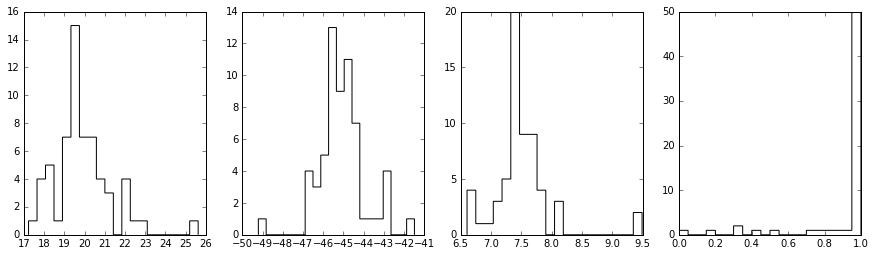

In [146]:
fig, ax = plt.subplots(1, 4, figsize=(15,4))

ax[0].hist(Pleiades['mu_ra_1'], histtype='step', bins=20, color='k')
ax[1].hist(Pleiades['mu_dec_1'], histtype='step', bins=20, color='k')
ax[2].hist(Pleiades['plx_1'], histtype='step', bins=20, color='k')
ax[3].hist(Pleiades['P_posterior'], histtype='step', bins=20, color='k')

plt.show()

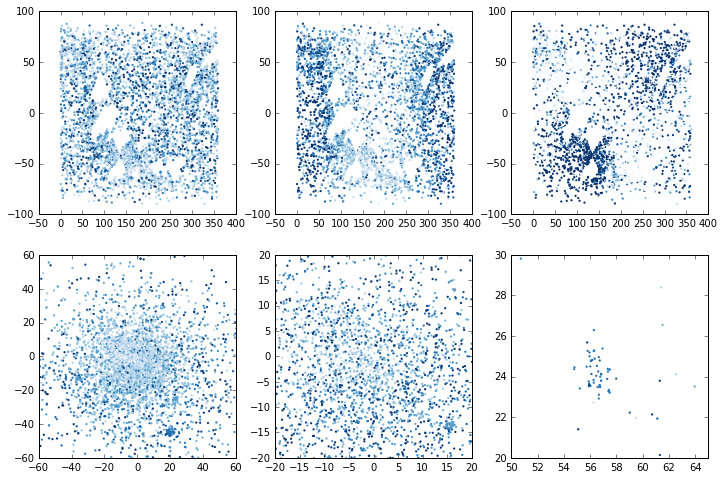

In [18]:
fig, ax = plt.subplots(2, 3, figsize=(12,8))


colors = np.min((tgas_full[TGAS_prob['i_1']]['plx'], 10.0 * np.ones(len(TGAS_prob))), axis=0) / 10.0
ax[0,0].scatter(tgas_full[TGAS_prob['i_1']]['ra'], tgas_full[TGAS_prob['i_1']]['dec'], c=colors, s=5, cmap='Blues', edgecolors='None')

colors = np.min((tgas_full[TGAS_prob['i_1']]['mu_ra']/50.0 + 0.5, np.ones(len(TGAS_prob))), axis=0)
colors = np.max((colors, np.zeros(len(TGAS_prob))), axis=0)
ax[0,1].scatter(tgas_full[TGAS_prob['i_1']]['ra'], tgas_full[TGAS_prob['i_1']]['dec'], c=colors, s=5, cmap='Blues', edgecolors='None')


colors = np.min((tgas_full[TGAS_prob['i_1']]['mu_dec']/10.0 + 0.5, np.ones(len(TGAS_prob))), axis=0)
colors = np.max((colors, np.zeros(len(TGAS_prob))), axis=0)
ax[0,2].scatter(tgas_full[TGAS_prob['i_1']]['ra'], tgas_full[TGAS_prob['i_1']]['dec'], c=colors, s=5, cmap='Blues', edgecolors='None')


colors = np.min((tgas_full[TGAS_prob['i_1']]['plx'], 10.0 * np.ones(len(TGAS_prob))), axis=0) / 10.0
ax[1,0].scatter(tgas_full[TGAS_prob['i_1']]['mu_ra'], tgas_full[TGAS_prob['i_1']]['mu_dec'], c=colors, s=5, cmap='Blues', edgecolors='None')
ax[1,0].set_xlim(-60, 60)
ax[1,0].set_ylim(-60, 60)


colors = np.min((tgas_full[TGAS_prob['i_1']]['plx'], 5.0 * np.ones(len(TGAS_prob))), axis=0) / 5.0
ax[1,1].scatter(tgas_full[TGAS_prob['i_1']]['mu_ra'], tgas_full[TGAS_prob['i_1']]['mu_dec'], c=colors, s=5, cmap='Blues', edgecolors='None')
ax[1,1].set_xlim(-20, 20)
ax[1,1].set_ylim(-20, 20)




colors = np.min((tgas_full[TGAS_prob['i_1']]['plx'], 10.0 * np.ones(len(TGAS_prob))), axis=0) / 10.0
ax[1,2].scatter(tgas_full[TGAS_prob['i_1']]['ra'], tgas_full[TGAS_prob['i_1']]['dec'], c=colors, s=5, cmap='Blues', edgecolors='None')
ax[1,2].set_xlim(50,65)
ax[1,2].set_ylim(20,30)


plt.show()

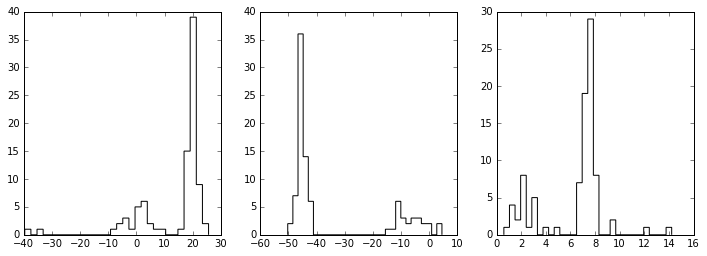

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(12,4))

#plt.hist(tgas_full[TGAS_prob['i_1']]['plx'], histtype='step', color='k')
#plt.hist(tgas_full[TGAS_prob['i_1']]['mu_ra'], histtype='step', color='k', range=(-20, 20))

idx1 = np.where(np.abs(tgas_full[TGAS_prob['i_1']]['ra'] - 57.0) < 3.0)[0]
idx2 = np.where(np.abs(tgas_full[TGAS_prob['i_1']]['dec'] - 24.0) < 3.0)[0]

idx = np.intersect1d(idx1, idx2)

#plt.scatter(tgas_full[TGAS_prob['i_1'][idx]]['ra'], tgas_full[TGAS_prob['i_1'][idx]]['dec'])

ax[0].hist(tgas_full[TGAS_prob['i_1'][idx]]['mu_ra'], histtype='step', bins=30, color='k')
ax[1].hist(tgas_full[TGAS_prob['i_1'][idx]]['mu_dec'], histtype='step', bins=30, color='k')
ax[2].hist(tgas_full[TGAS_prob['i_1'][idx]]['plx'], histtype='step', bins=30, color='k')

plt.show()